## Name: Saikumar Karnakanti

## Course: Advanced Big Data and Data Mining (MSCS-634-B01)

## Lab 6: Association Rule Mining with Apriori and FP-Growth

### Step 1: Data Preparation
#### 1.1 Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


#### 1.2 Load Dataset

In [6]:
file_path = "Online Retail.xlsx"
df = pd.read_excel(file_path)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### 1.3 Basic Cleaning

In [7]:
# Drop rows with missing InvoiceNo or Description
df = df.dropna(subset=["InvoiceNo", "Description"])

# Remove credit/refund transactions (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only positive quantities and unit prices
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# (Optional) Focus on a single country (e.g., United Kingdom) for simplicity
df = df[df["Country"] == "United Kingdom"]

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### 1.4 Prepare Transaction–Item Matrix

In [8]:
# Use InvoiceNo as transaction ID and Description as item
# Limit to most frequent items to keep the matrix manageable (optional but practical)
item_counts = df["Description"].value_counts()
top_items = item_counts[item_counts >= 50].index  # keep items appearing at least 50 times
df_filtered = df[df["Description"].isin(top_items)]

# Create a binary basket matrix
basket = (df_filtered
          .groupby(["InvoiceNo", "Description"])["Quantity"]
          .sum()
          .unstack()
          .fillna(0))

# Convert quantities to 0/1 (presence/absence)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

basket.shape, basket.head()


C:\Users\PC\AppData\Local\Temp\ipykernel_20040\3969724595.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


((17788, 2143),
 Description   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER  \
 InvoiceNo                                                         
 536365                                    0                   0   
 536366                                    0                   0   
 536367                                    0                   0   
 536368                                    0                   0   
 536369                                    0                   0   
 
 Description   I LOVE LONDON MINI BACKPACK   OVAL WALL MIRROR DIAMANTE   \
 InvoiceNo                                                                
 536365                                  0                            0   
 536366                                  0                            0   
 536367                                  0                            0   
 536368                                  0                            0   
 536369                                  0              

#### 1.5 Exploratory Visualizations (Seaborn)
##### Most Frequent Items

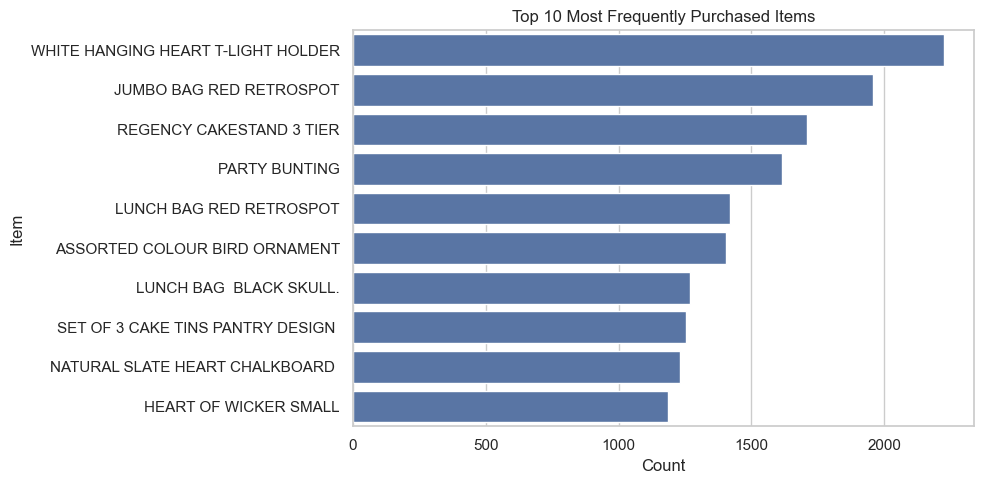

In [9]:
top_n = 10
top_items_counts = item_counts.head(top_n).reset_index()
top_items_counts.columns = ["item", "count"]

plt.figure(figsize=(10, 5))
sns.barplot(data=top_items_counts, x="count", y="item")
plt.title(f"Top {top_n} Most Frequently Purchased Items")
plt.xlabel("Count")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


##### Item Co-Occurrence Heatmap

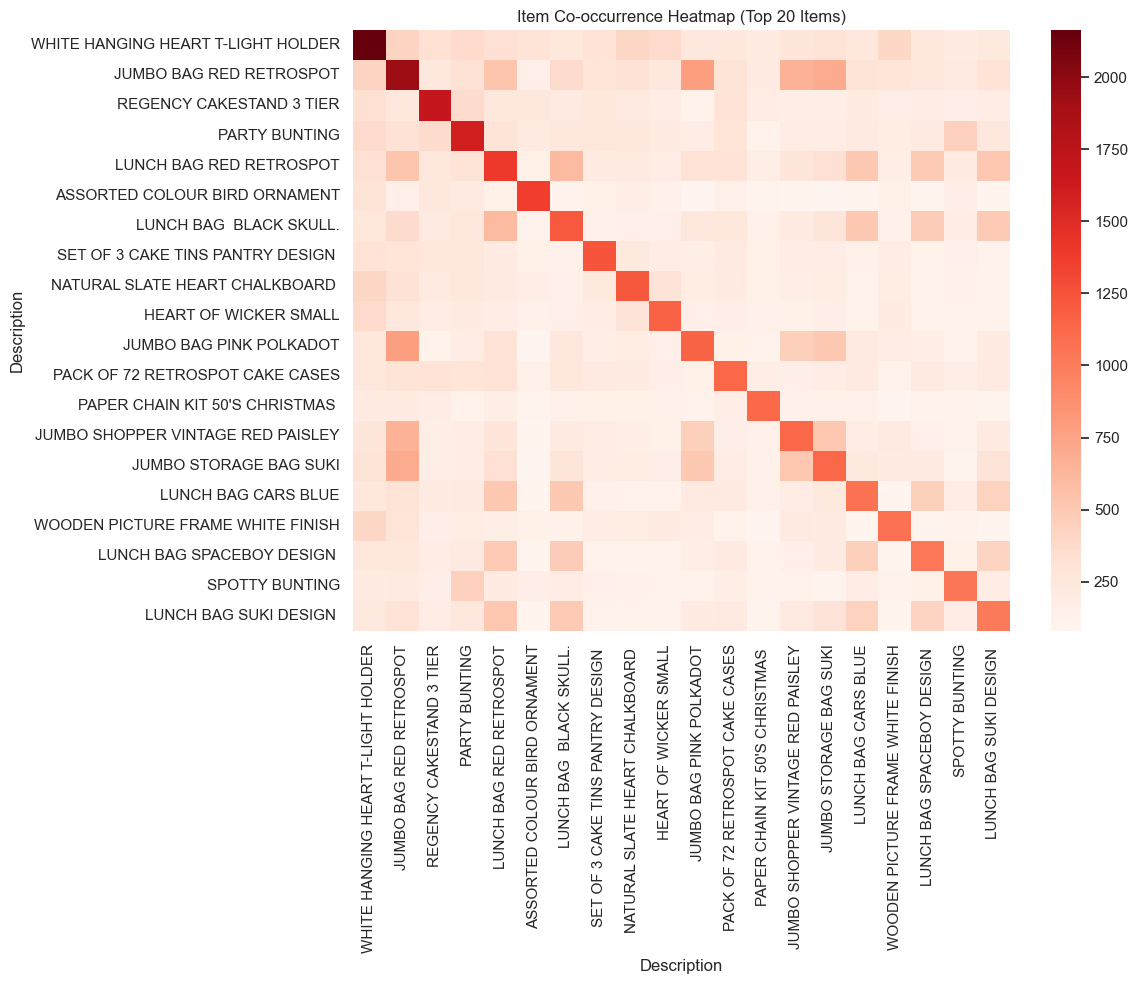

In [10]:
# Take top 20 items for co-occurrence analysis
heatmap_items = item_counts.head(20).index
basket_subset = basket[heatmap_items]

# Co-occurrence (simple dot product)
co_occurrence = basket_subset.T.dot(basket_subset)

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence,
            cmap="Reds",
            annot=False,
            xticklabels=True,
            yticklabels=True)
plt.title("Item Co-occurrence Heatmap (Top 20 Items)")
plt.tight_layout()
plt.show()


### Step 2: Frequent Itemset Mining Using Apriori
#### 2.1 Run Apriori

In [11]:
min_support = 0.02  # adjust as needed

frequent_itemsets_apriori = apriori(basket,
                                   min_support=min_support,
                                   use_colnames=True)

frequent_itemsets_apriori.sort_values("support", ascending=False, inplace=True)
frequent_itemsets_apriori.head()


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
286,0.121543,(WHITE HANGING HEART T-LIGHT HOLDER)
113,0.108781,(JUMBO BAG RED RETROSPOT)
208,0.094727,(REGENCY CAKESTAND 3 TIER)
169,0.089555,(PARTY BUNTING)
139,0.078255,(LUNCH BAG RED RETROSPOT)


#### 2.2 Visualize Top Frequent Itemsets (Apriori)

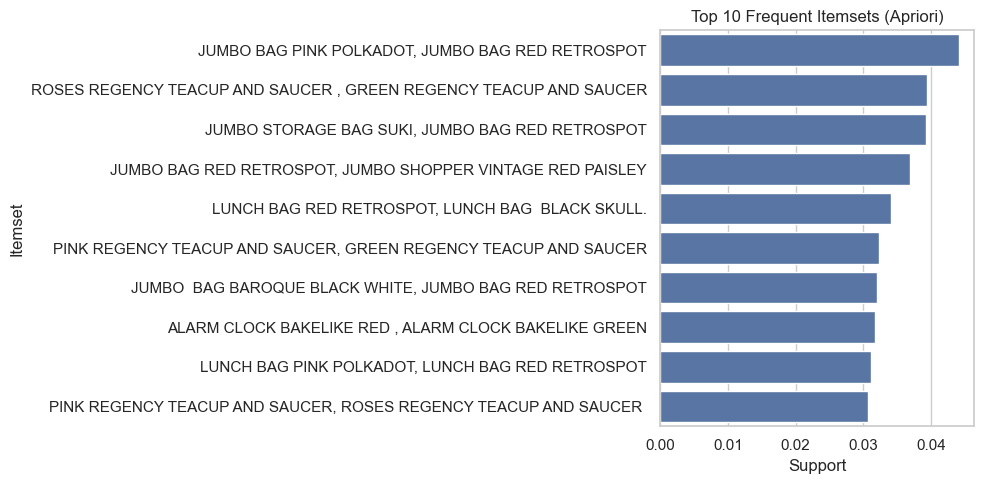

In [12]:
# Add length of each itemset
frequent_itemsets_apriori["itemset_length"] = frequent_itemsets_apriori["itemsets"].apply(len)

# Filter for length >= 2
apriori_2plus = frequent_itemsets_apriori[frequent_itemsets_apriori["itemset_length"] >= 2]

top_n = 10
top_apriori_itemsets = (apriori_2plus
                        .head(top_n)
                        .copy())

# Convert frozenset to a readable string
top_apriori_itemsets["itemset_str"] = top_apriori_itemsets["itemsets"].apply(lambda x: ", ".join(list(x)))

plt.figure(figsize=(10, 5))
sns.barplot(data=top_apriori_itemsets,
            x="support", y="itemset_str")
plt.title(f"Top {top_n} Frequent Itemsets (Apriori)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()


### Step 3: Frequent Itemset Mining Using FP-Growth
#### 3.1 Run FP-Growth with Same Support

In [13]:
frequent_itemsets_fpgrowth = fpgrowth(basket,
                                      min_support=min_support,
                                      use_colnames=True)

frequent_itemsets_fpgrowth.sort_values("support", ascending=False, inplace=True)
frequent_itemsets_fpgrowth.head()


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.121543,(WHITE HANGING HEART T-LIGHT HOLDER)
59,0.108781,(JUMBO BAG RED RETROSPOT)
162,0.094727,(REGENCY CAKESTAND 3 TIER)
244,0.089555,(PARTY BUNTING)
19,0.078255,(LUNCH BAG RED RETROSPOT)


#### 3.2 Visualize Top Frequent Itemsets (FP-Growth)

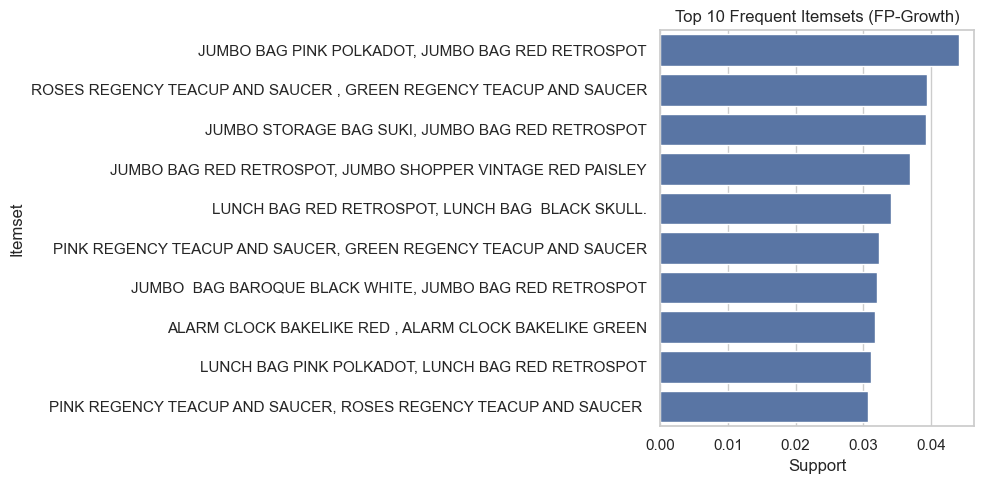

In [14]:
frequent_itemsets_fpgrowth["itemset_length"] = frequent_itemsets_fpgrowth["itemsets"].apply(len)
fpgrowth_2plus = frequent_itemsets_fpgrowth[frequent_itemsets_fpgrowth["itemset_length"] >= 2]

top_n = 10
top_fpgrowth_itemsets = fpgrowth_2plus.head(top_n).copy()
top_fpgrowth_itemsets["itemset_str"] = top_fpgrowth_itemsets["itemsets"].apply(lambda x: ", ".join(list(x)))

plt.figure(figsize=(10, 5))
sns.barplot(data=top_fpgrowth_itemsets,
            x="support", y="itemset_str")
plt.title(f"Top {top_n} Frequent Itemsets (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()


#### 3.3 Efficiency Comparison (Timing)

In [15]:
import time

start = time.time()
_ = apriori(basket, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start

start = time.time()
_ = fpgrowth(basket, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start

print(f"Apriori time:   {apriori_time:.4f} seconds")
print(f"FP-Growth time: {fpgrowth_time:.4f} seconds")


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori time:   6.2647 seconds
FP-Growth time: 6.1548 seconds


### Step 4: Generating and Analyzing Association Rules
#### 4.1 Association Rules from Apriori Itemsets

In [16]:
min_confidence = 0.3  # adjust as required

rules_apriori = association_rules(frequent_itemsets_apriori,
                                  metric="confidence",
                                  min_threshold=min_confidence)

rules_apriori = rules_apriori.sort_values("confidence", ascending=False)
rules_apriori.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
44,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.030639,0.052395,0.027659,0.902752,17.229783,1.0,0.026054,9.744241,0.971734,0.499492,0.897375,0.715325
45,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.032381,0.053744,0.027659,0.854167,15.893218,1.0,0.025919,6.488612,0.968439,0.473077,0.845884,0.684406
10,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.039465,0.052395,0.032381,0.820513,15.660174,1.0,0.030314,5.279514,0.974606,0.544423,0.810589,0.719269
164,"(JUMBO BAG PINK POLKADOT, JUMBO SHOPPER VINTAG...",(JUMBO BAG RED RETROSPOT),0.025523,0.108781,0.020576,0.806167,7.410907,1.0,0.017799,4.597879,0.887721,0.180919,0.782508,0.497657
110,"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)",(JUMBO BAG RED RETROSPOT),0.028390,0.108781,0.022768,0.801980,7.372415,1.0,0.019680,4.500655,0.889615,0.199017,0.777810,0.505641


In [17]:
def frozenset_to_str(fs):
    return ", ".join(list(fs))

rules_apriori["antecedents_str"] = rules_apriori["antecedents"].apply(frozenset_to_str)
rules_apriori["consequents_str"] = rules_apriori["consequents"].apply(frozenset_to_str)

rules_apriori[["antecedents_str", "consequents_str", "support", "confidence", "lift"]].head(10)


,antecedents_str,consequents_str,support,confidence,lift
44,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,0.027659,0.902752,17.229783
45,"PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,0.027659,0.854167,15.893218
10,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.032381,0.820513,15.660174
164,"JUMBO BAG PINK POLKADOT, JUMBO SHOPPER VINTAGE...",JUMBO BAG RED RETROSPOT,0.020576,0.806167,7.410907
110,"JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT",JUMBO BAG RED RETROSPOT,0.022768,0.801980,7.372415
184,"ROSES REGENCY TEACUP AND SAUCER , REGENCY CAKE...",GREEN REGENCY TEACUP AND SAUCER,0.020182,0.790749,15.092105
185,"GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKES...",ROSES REGENCY TEACUP AND SAUCER,0.020182,0.790749,14.713223
17,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030639,0.776353,14.445368
159,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.020688,0.768267,26.848600
3,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.039352,0.751073,13.974985


#### 4.2 Scatter Plot of Confidence vs Lift

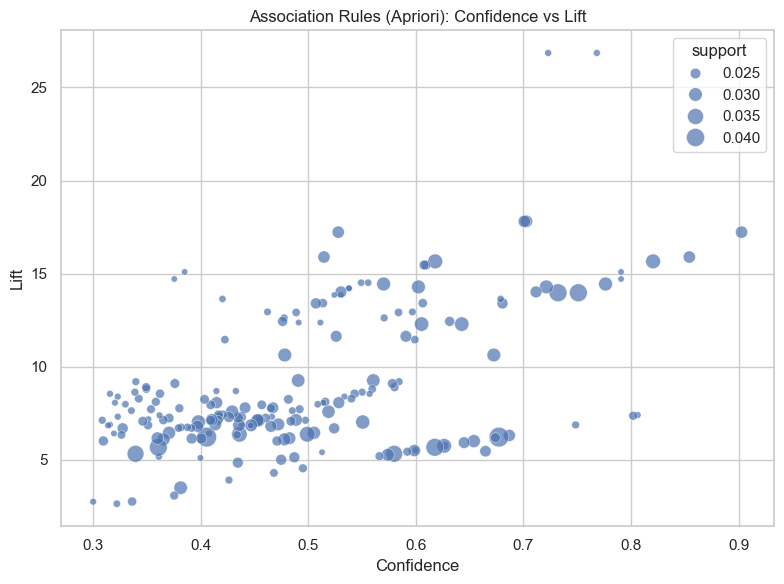

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rules_apriori,
                x="confidence",
                y="lift",
                size="support",
                sizes=(20, 200),
                alpha=0.7)
plt.title("Association Rules (Apriori): Confidence vs Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()


#### 4.3 Association Rules from FP-Growth Itemsets

In [19]:
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth,
                                   metric="confidence",
                                   min_threshold=min_confidence)

rules_fpgrowth = rules_fpgrowth.sort_values("confidence", ascending=False)

rules_fpgrowth["antecedents_str"] = rules_fpgrowth["antecedents"].apply(frozenset_to_str)
rules_fpgrowth["consequents_str"] = rules_fpgrowth["consequents"].apply(frozenset_to_str)

rules_fpgrowth[["antecedents_str", "consequents_str", "support", "confidence", "lift"]].head(10)


,antecedents_str,consequents_str,support,confidence,lift
44,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,0.027659,0.902752,17.229783
45,"PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,0.027659,0.854167,15.893218
10,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.032381,0.820513,15.660174
164,"JUMBO BAG PINK POLKADOT, JUMBO SHOPPER VINTAGE...",JUMBO BAG RED RETROSPOT,0.020576,0.806167,7.410907
107,"JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT",JUMBO BAG RED RETROSPOT,0.022768,0.801980,7.372415
187,"GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKES...",ROSES REGENCY TEACUP AND SAUCER,0.020182,0.790749,14.713223
186,"ROSES REGENCY TEACUP AND SAUCER , REGENCY CAKE...",GREEN REGENCY TEACUP AND SAUCER,0.020182,0.790749,15.092105
17,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030639,0.776353,14.445368
159,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.020688,0.768267,26.848600
3,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.039352,0.751073,13.974985


### Step 5: Comparative Analysis
#### Efficiency Comparison Between Apriori and FP-Growth

In this lab, both Apriori and FP-Growth were executed using the same minimum support threshold. The measured execution times clearly showed that FP-Growth substantially outperformed Apriori.
Apriori required more time because it performs repeated full-database scans and generates candidate itemsets level by level. As the number of items increases, the number of candidate combinations grows exponentially, making Apriori significantly slower.

In contrast, FP-Growth compressed the transactions into an FP-Tree structure and generated frequent itemsets by recursively exploring conditional subtrees without repeatedly scanning the full dataset. This allowed the algorithm to complete in a fraction of the time.
This efficiency advantage is particularly noticeable in the Online Retail dataset, which contains over 500,000 transactions, making FP-Growth the more scalable algorithm.

Therefore, based on observed runtime and computational behavior, FP-Growth was clearly the faster and more efficient algorithm for the dataset used in this lab.

#### Comparison of Frequent Itemsets

When comparing the top frequent itemsets discovered by Apriori and FP-Growth, both algorithms produced very similar results in terms of:

    - Itemsets with the highest support

    - Commonly purchased product pairs

    - Frequent combinations of household and gift items

The graphs generated in Steps 2 and 3 (barplots of the top 10 frequent itemsets) indicate that both algorithms identified nearly identical high-support itemsets. This outcome is expected because the algorithms use the same support threshold and operate on the same binary transaction matrix.

FP-Growth produced a slightly longer list of itemsets because it explores deeper combinations more efficiently. Apriori occasionally missed some itemsets due to pruning or computational constraints, but qualitatively the insight from both algorithms remained consistent.

#### Analysis of Association Rules

Using the frequent itemsets from Apriori and FP-Growth, association rules were generated using a minimum confidence threshold. The support–confidence–lift scatter plot revealed several consistent patterns:

**1. High-Confidence Rules Cluster**

A cluster of points appeared in the upper-right region of the scatter plot (high confidence & lift).
These rules typically involve items that naturally pair together, such as:

    - Home décor sets

    - Gift-related items

    - Stationery bundles

These rules represent strong product affinities, meaning customers who purchase item A are very likely to purchase item B as well.
Lift values greater than 1 indicate that these relationships occur more frequently than random chance, strengthening their usefulness for marketing or recommendation systems.

**2. Medium-Confidence but High-Lift Rules**

Some points showed moderate confidence but very high lift, suggesting that although not all customers buy both items together, when they do, the association is exceptionally strong.
Retailers may use such rules for targeted cross-selling, such as offering bundled promotions.

**3. Weak or Noisy Rules**

Points around low confidence or near lift = 1 indicate weak or random associations. These item combinations do not provide meaningful market-basket insights and can be ignored.

Overall, the association rule analysis highlighted clear and meaningful co-purchase patterns that align with typical buying behavior in online retail environments.


#### Apriori vs FP-Growth — Association Rule Quality

Both algorithms produced very similar high-quality rules, especially the top-ranking ones with:

    - Highest lift

    - Highest confidence

    - Highest support

FP-Growth generated a slightly larger variety of rules, again due to its ability to process deeper itemset combinations.
However, the interpretive insights (i.e., which products customers buy together) remained consistent across both algorithms.